# Etap 6 - Klasyfikator, reguły, profil charakterystyczny i wiedza dla youtubera
 * Wybranie miar oceny klasyfikatora (nie tylko trafność predykcji / zwłaszcza
binarne - mogą prowadzić do wielu miar, także gdy dane są niezbalansowanych -
wtedy dobrać właściwe)
 * Opracowanie klasyfikatora dla wersji trending / non-trending (interpretowalnego! -
można zastosować różne podejścia - np. specjalne wizualizacje dla black boxes)
 * Stworzenie profilu charakterystycznych wartości atrybutów dla klasy trending /otwarty problem jak to zrobić i jakie podejścia do oceny wybrać (mogą być np.
specjalne miary oceny reguł)
 * Opracowanie wiedzy dla klienta - co powinien robić, jakie sztuczki stosować,
czego się wystrzegać, jeśli chce żeby jego filmy trafiły do klasy trending
 * OCENA (15%)
  * 4% pierwszy klasyfikator (z wyjaśnieniem)
  * 4% drugi klasyfikator (z wyjaśnieniem) + wybór
  * 7% opracowanie wiedzy dla klienta

# Analysis

In [0]:
!pip install --upgrade tables # pd.read_hdf bug
!pip install --upgrade shap

## Constants

In [0]:
DATA_TRENDING = 'data_c12.hdf'
DATA_CAT = 'cat_mapping.csv'
DATA_NON_TRENDING = 'data_c6.hdf'
DATA_OBJ_TR = 'objects_tr.csv'
DATA_OBJ_NON_TR = 'objects_nontr.csv'
DATA_NT_BRT = 'non_brightness.csv'

## Imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import imblearn
from scipy.stats import chi2_contingency
from google.colab import drive # Google Drive connection
from os import path, cpu_count
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [0]:
style.use('seaborn-poster') 
style.use('ggplot')

## Google Drive

In [31]:
# Mount google drive and load data
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = path.join(drive_path , 'datasets/youtube_data')
image_path = path.join(data_path, 'images')
cache_path = path.join(drive_path, 'cache')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the data

In [0]:
df = pd.read_hdf(path.join(data_path, DATA_TRENDING))

time = ['publish_day', 'publish_hour', 'publish_month'] 
cos = [x + '_cos' for x in time]
sin = [x + '_sin' for x in time]

to_remove = ['trending_date', 'title', 'channel_title', 'tags', 
             'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 
             'description', 'publish_date', 'time_to_viral', 'tags_split',
             'title_split', 'title_alpha', 'trend_pub_date_diff', 'desc_clean',
             'desc_split', 'links', 'tokens', 'desc_preproc', 'tf_idf_vector', 
             'palette', 'resNet_vec', 'hog_vec', 'dominant_color', 
             'publish_time', 
             'trending_date_conv', 'trending_month', 'obj_vec']
to_remove += cos
to_remove += sin
df = df.drop(to_remove, axis=1)

Fill the categories in trending

In [0]:
df_cat = pd.read_csv(path.join(data_path, DATA_CAT))
def find_cat(x):
  cat = df_cat[df_cat.video_id == x].true_cat.values
  if len(cat) == 0:
    return None
  if len(cat) == 1:
    return cat[0]
  else:
    raise ValueError("More than one category matching")
df.category_id = df.video_id.apply(find_cat)

Add detected objects data

In [34]:
df_t_obj = pd.read_csv(path.join(data_path, DATA_OBJ_TR), 
                       sep=';', 
                       error_bad_lines=False)
df = df.merge(df_t_obj, on='video_id')

b'Skipping line 6755: expected 73 fields, saw 144\n'


Load non-trending and remove unused

In [0]:
df_n = pd.read_hdf(path.join(data_path, DATA_NON_TRENDING))
to_remove_nt = set(df_n.columns) & set(to_remove)
df_n = df_n.drop(columns=to_remove_nt)

Add detected objects to non-trending

In [36]:
df_nt_obj = pd.read_csv(path.join(data_path, DATA_OBJ_NON_TR), 
                       sep=';', 
                       error_bad_lines=False)
df_n = df_n.merge(df_nt_obj, on='video_id')

b'Skipping line 24434: expected 73 fields, saw 144\n'
b'Skipping line 24733: expected 73 fields, saw 144\nSkipping line 24765: expected 73 fields, saw 144\n'


Add brightness to non_trending

In [37]:
df_nt_br = pd.read_csv(path.join(data_path, DATA_NT_BRT),
                       sep=';',
                       error_bad_lines=False)
df_n = df_n.merge(df_nt_br, on='video_id')
df_n['trending'] = False
df['trending'] = True
df = df.append(df_n)
df = df.drop(columns=['video_id'])
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df.shape
df.loc[:, 'category_id'] = pd.Categorical(df.category_id)
cat_vars = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
for var in cat_vars:
  cont_tab = pd.crosstab(index=df['trending'], columns=df[var])
  test = chi2_contingency(cont_tab)
  print('Var: %s\tp_value: %.2E' % (var, test[1]))

Var: comments_disabled	p_value: 1.09E-239
Var: ratings_disabled	p_value: 1.20E-50
Var: video_error_or_removed	p_value: 8.62E-07


The boolean variables are statistically significant

## Classifiers

### Splitting the dataset

In [0]:
df.category_id = df.category_id.astype(int)
X = df.drop(columns=['trending'])
y = df.trending
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4,
                                                    stratify=y, 
                                                    random_state=1996)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5,
                                                    stratify=y_test, 
                                                    random_state=1996)

In [0]:
def score(clf, data='valid', number=True):
  if data == 'valid':
    y_true = y_valid
    X = X_valid
  elif data =='test':
    y_true = y_test
    X = X_test
  else:
    y_true = y_train
    X = X_train
  y_pred = clf.predict(X)
  print(metrics.classification_report(y_true, y_pred))

### Logistic regression

In [40]:
clf = LogisticRegression(max_iter=1000, 
                         n_jobs=cpu_count(), 
                         penalty='none', 
                         multi_class='ovr')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.87      0.98      0.92     23697
        True       0.71      0.29      0.41      4756

    accuracy                           0.86     28453
   macro avg       0.79      0.63      0.67     28453
weighted avg       0.85      0.86      0.84     28453



In [42]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      7899
        True       0.72      0.27      0.39      1586

    accuracy                           0.86      9485
   macro avg       0.79      0.62      0.66      9485
weighted avg       0.84      0.86      0.83      9485



We have very low _recall_ on the trending (**1**, _positive_) class. The dataset is imbalanced. We will apply naive undersampling on the majority class.

### Undersampling

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
rus = RandomUnderSampler(random_state=1996)

In [0]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [0]:
clf.fit(X_under, y_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.95      0.75      0.84     23697
        True       0.39      0.79      0.52      4756

    accuracy                           0.76     28453
   macro avg       0.67      0.77      0.68     28453
weighted avg       0.85      0.76      0.79     28453



In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.94      0.75      0.84      7899
        True       0.38      0.77      0.51      1586

    accuracy                           0.76      9485
   macro avg       0.66      0.76      0.68      9485
weighted avg       0.85      0.76      0.78      9485



Naive undersampling improved the _recall_ but dropped the _precision_. We will try _SMOTE_ and _Tomek Links_

### TomekLinks

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [0]:
Counter(y_train)

Counter({False: 23697, True: 4756})

In [0]:
tm = TomekLinks(random_state=1996, sampling_strategy='majority')
X_tomek, y_tomek = tm.fit_resample(X_train, y_train)
Counter(y_tomek)

In [0]:
sm = SMOTE(random_state=1996)
X_smote, y_smote = sm.fit_resample(X_tomek, y_tomek)
Counter(y_smote)

In [0]:
clf.fit(X_smote, y_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.95      0.76      0.84     23697
        True       0.39      0.78      0.52      4756

    accuracy                           0.76     28453
   macro avg       0.67      0.77      0.68     28453
weighted avg       0.85      0.76      0.79     28453



In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.94      0.76      0.84      7899
        True       0.39      0.77      0.52      1586

    accuracy                           0.76      9485
   macro avg       0.67      0.76      0.68      9485
weighted avg       0.85      0.76      0.79      9485



Precision on the _trending_ class imporoved by **1%**. We are clearly underfitting. Neural network classifier will be tried.

### Neural Network

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid

In [0]:
params = {
    'lr': 10.0**np.arange(-6,0),
    'alpha': 10.0**np.arange(-4,1)
}

best_params = None
best_score = 0

for param in ParameterGrid(params):
  print(param)
  lr = param['lr']
  alpha = param['alpha']
  clf = MLPClassifier(hidden_layer_sizes=(1024),
                    solver='adam',
                    learning_rate_init=lr,
                    activation='logistic',
                    alpha=alpha,
                    max_iter=10)
  clf.fit(X_smote, y_smote)
  y_pred = clf.predict(X_valid)
  score = metrics.f1_score(y_pred, y_valid)
  if score > best_score:
    best_params = param
    best_score = score

In [0]:
print('Best validation score: %.2f %%' % (best_score*100))
print(best_params)

Best validation score: 69.44 %
{'alpha': 0.001, 'lr': 0.01}


In [0]:
learning_rate = 0.01
alpha = 0.001 # regularization lambda

clf = MLPClassifier(hidden_layer_sizes=(1024),
                  solver='adam',
                  learning_rate_init=learning_rate,
                  activation='logistic',
                  alpha=alpha,
                  max_iter=300,
                  verbose=True)

clf.fit(X_smote, y_smote)

In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.97      0.88      0.92      7899
        True       0.59      0.87      0.70      1586

    accuracy                           0.88      9485
   macro avg       0.78      0.87      0.81      9485
weighted avg       0.91      0.88      0.88      9485



We can see a big improvement comparing to **Logistic regression**.
Using a shallow **Neural Network** with **1** hidden layer of **1024** units we've achieved **70%** _f1-score_ on _trending_ class. 

In [0]:
import joblib
joblib.dump(clf, path.join(data_path, 'clf_nn.joblib'))
#clf = joblib.load(path.join(data_path, 'clf_nn.joblib'))

['/content/drive/My Drive/datasets/youtube_data/clf_nn.joblib']

### CatBoost

CatBoost is a machine learning algorithm that uses gradient boosting on decision trees. It is available as an open source library. Judging on our previous experiences, it is powerful and relatively fast. It also offers ready to use methods for explainig the model.

In [0]:
!pip install catboost
!pip install shap
from catboost import CatBoostClassifier, Pool
import shap

In [0]:
xgb = CatBoostClassifier(iterations=500,
                           depth=10,
                           learning_rate=0.05,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=[df.columns.get_loc("category_id")],
                           use_best_model=True)

In [0]:
y_valid = y_valid
y_test = y_test
y_train = y_train
eval_pool = Pool(X_valid, y_valid, cat_features=[df.columns.get_loc("category_id")])
test_pool = Pool(X_test,  y_test, cat_features=[df.columns.get_loc("category_id")])
train_pool = Pool(X_train, y_train, cat_features=[df.columns.get_loc("category_id")])

In [64]:
xgb.fit(X_train, y_train, eval_set=eval_pool)

In [65]:
valid_pred = xgb.predict(X_valid)
valid_pred = np.where(valid_pred=='True', 1, 0)
print(metrics.classification_report(valid_pred, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8210
           1       0.78      0.97      0.86      1275

    accuracy                           0.96      9485
   macro avg       0.89      0.96      0.92      9485
weighted avg       0.97      0.96      0.96      9485



We achieved quite good results for CatBoost with depth 10 on validation dataset - **86%** on F1 measure for trending class. Therefore, we choose this classifier as a final solution.

In [89]:
test_pred = xgb.predict(X_test)
test_pred = np.where(test_pred=='True', 1, 0)
print(metrics.classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8188
           1       0.79      0.97      0.87      1297

    accuracy                           0.96      9485
   macro avg       0.89      0.96      0.92      9485
weighted avg       0.97      0.96      0.96      9485



The results on test set are even better.

## Explanation - Neural Network

The **Neural Network** explanation will be performed using _SHAP_.
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [0]:
import shap
import warnings
shap.initjs()

In [0]:
def predict(X):
  return clf.predict_proba(X)[:,1]

array([0.16023455, 0.00499579, 0.05570258, ..., 0.10729287, 0.0009743 ,
       0.15658926])

In [0]:
explainer = shap.KernelExplainer(predict, 
                                 shap.kmeans(X_test, 10), 
                                 link="logit")

In [0]:
warnings.filterwarnings('ignore')
shap_values = explainer.shap_values(X_test.astype(float), nsamples=100)

In [0]:
joblib.dump(clf, path.join(data_path, 'clf_nn.joblib'))

### General impact

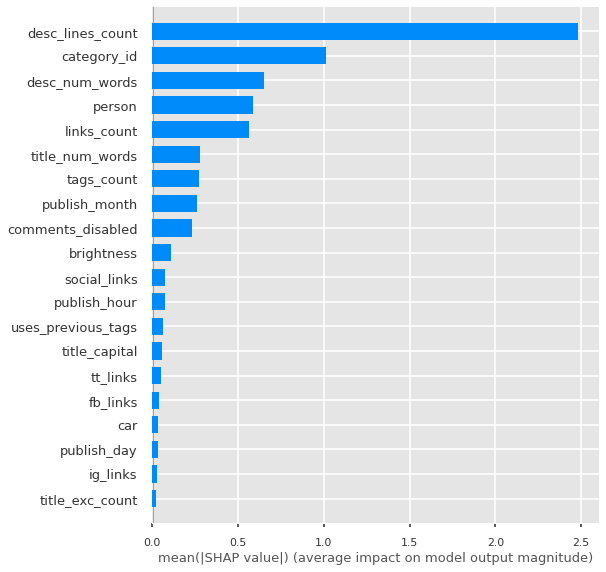

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

On the figure above, we can see the most important features for the model.
We can clearly see the significance of the **description length**. Category is also considered important.

After those two we have a set of 3 next ones:
 * Number of words in the descriptions
 * Number of people identified on the thumbnail
 * Number of links in the description  

Later on we could extract another _cluster_:
 * Number of words in title
 * Number of tags
 * The publish month
 * If the comments are disabled

### Direction-oriented analysis

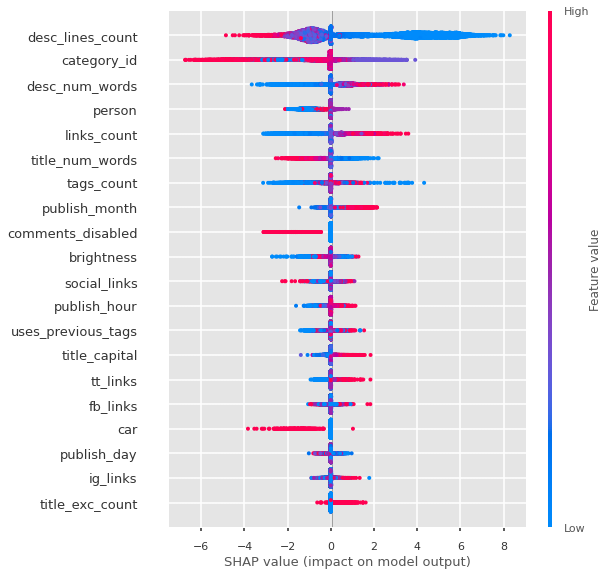

In [0]:
shap.summary_plot(shap_values, X_test, 
                  plot_type='dot', 
                  max_display=20)

On the figure above, we can see how does a feature value (in terms of color), directs the output either in _non-trending_ (left) or _trending_ (right) side.

#### Comments

One of the clearest examples is _comments\_disabled_ feature. We can see, that **disabling comments** is a bad idea, because it always directs a video into the _non-trending_ category.

#### Description length

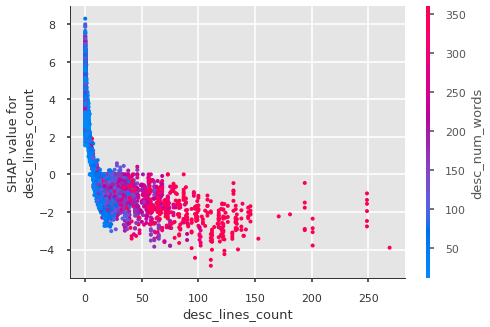

In [0]:
shap.dependence_plot('desc_lines_count', shap_values, X_test, interaction_index='desc_num_words')

Description has the greatest impact on the model's output. As we can see on the plot above, a **short description with a very few lines and a small number of wrods** is the best option to direct the prediction into _trending_ zone (positive _SHAP_ values). The longer the description, the lower the odds of getting into training.

#### Category

It's a matter of the discusion if the category is manipulable when thinking about increasing videos chances to get trending. It is clear however, that category is a important factor in the prediction.

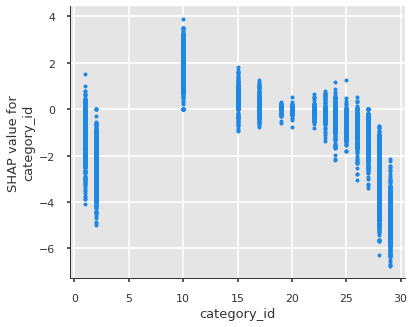

In [0]:
shap.dependence_plot('category_id', shap_values, X_test, 
                     interaction_index=None)

#### Person

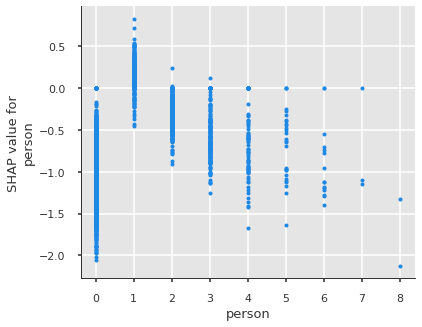

In [0]:
shap.dependence_plot('person', shap_values, X_test, 
                     interaction_index=None)

Having no person on the thumbnail directs the odds towards _non-trending_.
It's good to have exactly one person to increase the odds of getting _trending_.

#### Links

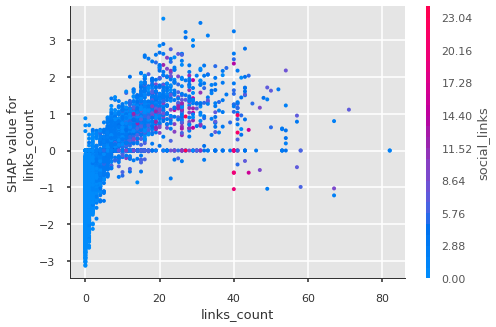

In [0]:
shap.dependence_plot('links_count', 
                     shap_values, 
                     X_test, 
                     interaction_index='social_links')

The general conclusion is:
* A moderate number of links (more than 20) shouldn't direct the prediction into non-trending area.
* Social links could sometimes help

#### Title

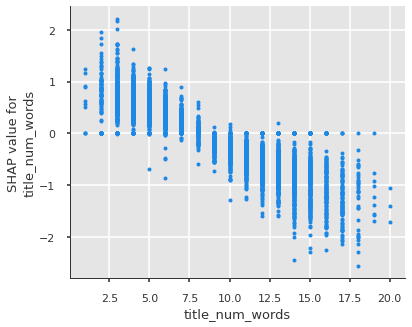

In [0]:
shap.dependence_plot('title_num_words', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

A short title (up to ~7 words) directs the prediction towards _trending_. Longer titles seem to be a bad idea.

#### Number of tags

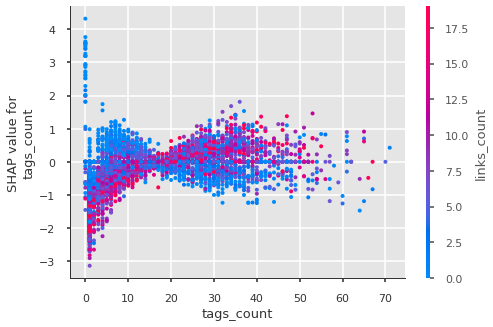

In [0]:
shap.dependence_plot('tags_count', 
                     shap_values, 
                     X_test)

The impact of the numbers of the tags is less clear, but can be grasped, when compared to the number of links in description. Using a high number of tags and high number of links in description, helps to direct the prediction towards _treidning_.

#### Publish month

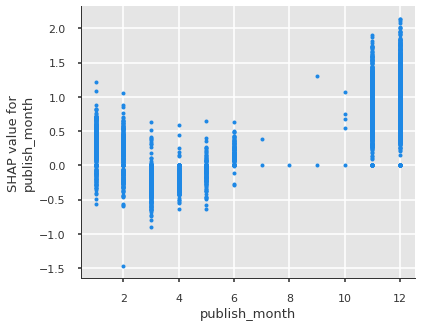

In [0]:
shap.dependence_plot('publish_month', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We can see a strong bias of some months towards _trending_. This needs to be interpreted carefully - the distribution of the _publish\_month_ across the classes should be checked.

#### Publish hour

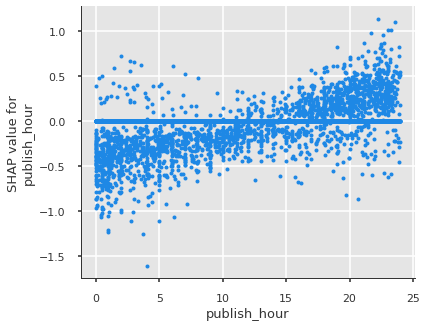

In [0]:
shap.dependence_plot('publish_hour', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We can see, that publishin the video in the late evening hours, directs the prediction towards _trending_.  

#### Title capital

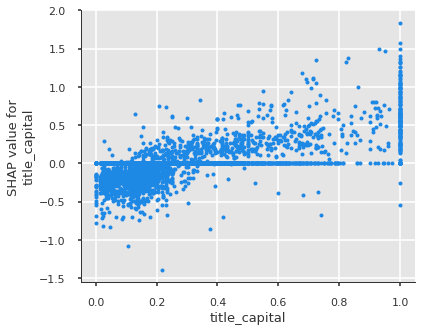

In [0]:
shap.dependence_plot('title_capital', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

It is a good idea to use a lot of capital letters in title.

#### Car

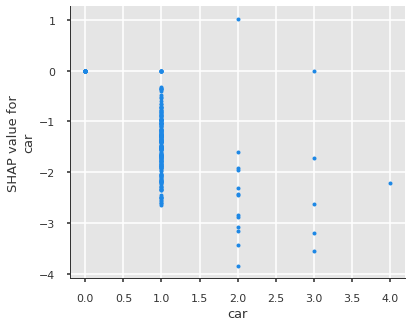

In [0]:
shap.dependence_plot('car', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

It's better not to have a car on thumbnail - a strange conclusion that seems to hold in most of the cases.

## General conclusions from Neural Network analysis

We can draw the following advices from the _Neural Network_ analysis to increase the video's chances to get trending:
 * Don't disable comments
 * Use short description
 * If the content fits more than one category, choose the one increasing the odds of gettin trending
 * Including some social links can be helpful
 * Title should be short (definitely shouldn't extend ~7 words)
 * Using a lot of capitals in the title is a good idea
 * Have exactly one person on the thumbnail (and avoid cars)
 * Publish the video in the middle of the night

## Explanation - CatBoost

In [66]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### General impact

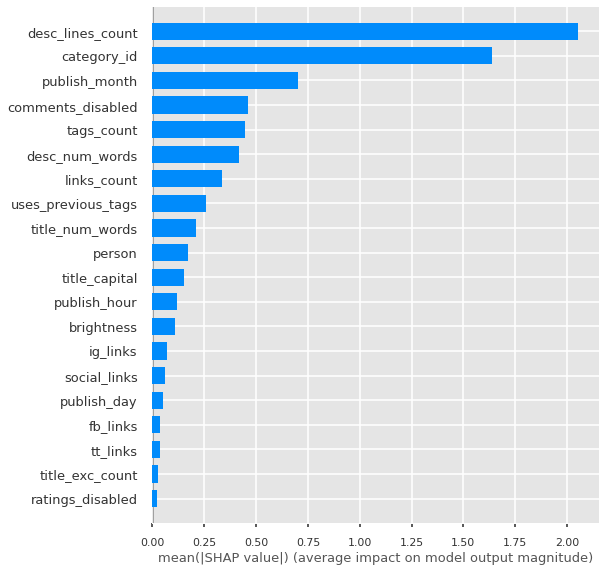

In [67]:
shap.summary_plot(shap_values, X, plot_type="bar")

In XGB model th most significant is also number of lines in the description. Category is also very important. The third significant feature is month of publication. Then, there are three features, which have similar impact:
 * if the comments are disabled
 * number of tags 
 * number of words in description

Number of links in descrpition and using tags popular in other trending videos are also worth mentioning. Other features don't have big impact on the output.  


### Direction-oriented analysis

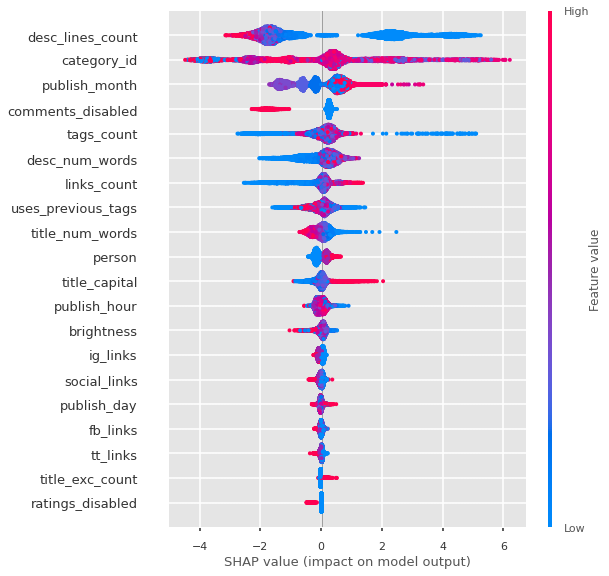

In [68]:
shap.summary_plot(shap_values, X_test, 
                  plot_type='dot', 
                  max_display=20)

#### Description length - lines


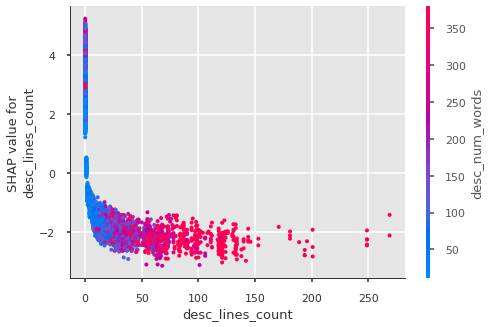

In [69]:
shap.dependence_plot('desc_lines_count', shap_values, X_test, interaction_index='desc_num_words')

Number of lines in the description seems is the most important feature in prediction - we can observe, that descriptions with only a few lines are pushing prediction into trending videos - probably constructing concise description is vital for getting into trending list.

Category

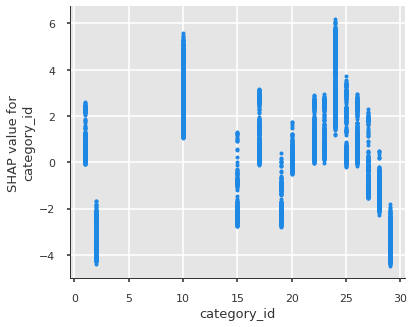

In [71]:
shap.dependence_plot('category_id', shap_values, X_test, interaction_index=None)

We can state that videos belonging to some categories are more supposed to get viral, because some of them concern more people, while others are viewed only by specific groups of people - e.g. with very specific intersets.

The most trending category seems to be 24 - Entertainment and 10 - Music.

#### Publish month

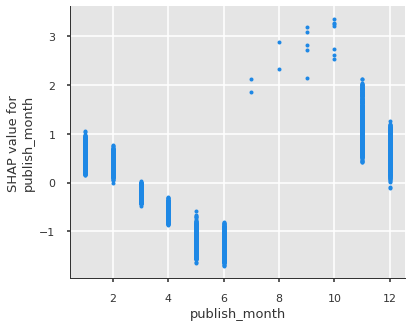

In [72]:
shap.dependence_plot('publish_month', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We should chcek the distribution of months across the classes. It is hard to explain why videos published in November and December bias the classifier into trending class.

#### Disabling comments

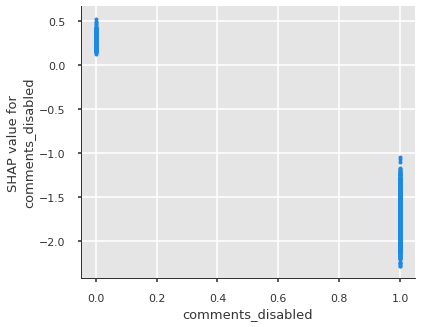

In [83]:
shap.dependence_plot('comments_disabled', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

As we could see from general plot, disabling comment doesn't have a good impact being trendy.

#### Number of tags

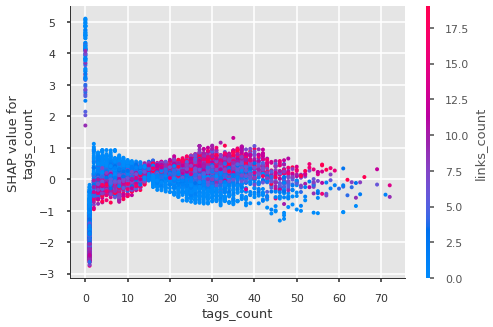

In [73]:
shap.dependence_plot('tags_count', 
                     shap_values, 
                     X_test)

The impact of tags is not so easy to interpret, but we can observe, that having a good balance between tags and links can be helpful - either several links and tags or many tags and many links.

#### Description length - words

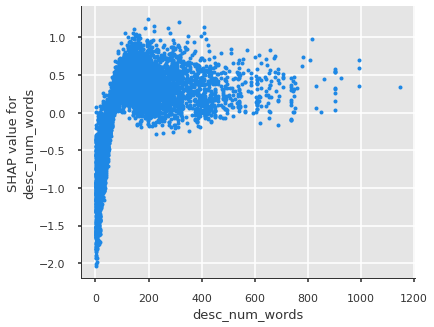

In [81]:
shap.dependence_plot('desc_num_words', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

Having in mind the plot of number of lines in the description, we can observe quite unexpected dependence - for getting trending it is good to have small number of lines in the description, but on the other hand - a lot of words. So we can state, that the description should be short in terms of lines and longs in terms of words - it should be constructed of few long lines.

#### Links

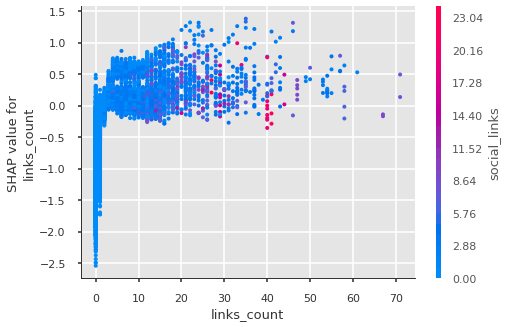

In [78]:
shap.dependence_plot('links_count', 
                     shap_values, 
                     X_test, 
                     interaction_index='social_links')

Not having any links or very small number of them seems to bias classifier into non-trending videos. It is good to place at least several in the description. This phenomenon can be explained also in wider view: if you want to be popular, build your popularity not only on YouTube, but also in other places, especially social media.

#### Using popular tags

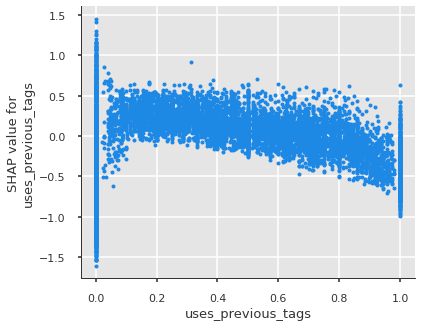

In [79]:
shap.dependence_plot('uses_previous_tags', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

Using tags popular in other trending videos can be helpful sometimes, but not always. Probably some videos followed latest trends and were popular because of that, but the majority must have been somehow innovative and outstanding to catch watchers attention.

#### Title length

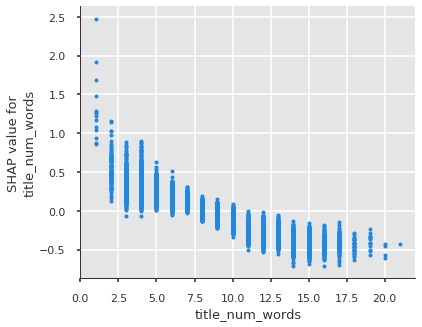

In [75]:
shap.dependence_plot('title_num_words', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

Short, eye-catching titles are more likely to catch the viewer eye.

#### Person

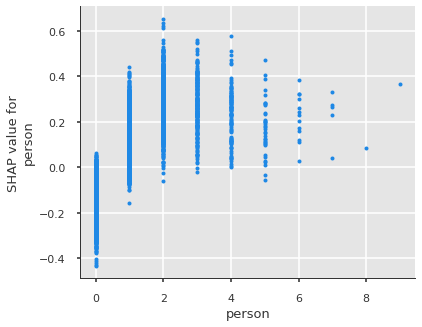

In [80]:
shap.dependence_plot('person', shap_values, X_test, 
                     interaction_index=None)

People occuring on video miniature can help in drawing attention to the video. 

#### Capital letters in title

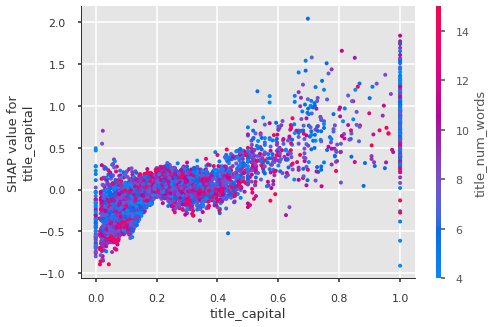

In [87]:
shap.dependence_plot('title_capital', shap_values, X_test, 
                     interaction_index='title_num_words')

Using a lot of capital letters in title seems to draw attention to the video.

#### Publish hour


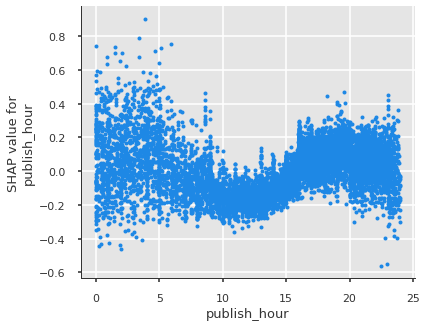

In [90]:
shap.dependence_plot('publish_hour', shap_values, X_test, 
                     interaction_index=None)

Popular videos were uploaded more often in the night

#### Social links

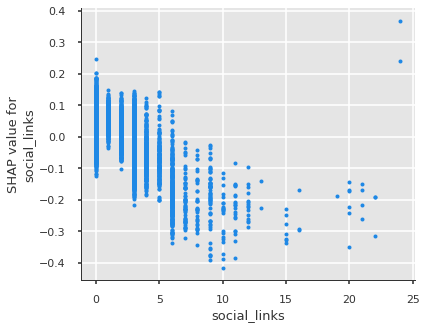

In [88]:
shap.dependence_plot('social_links', shap_values, X_test, 
                     interaction_index=None)

Including too many links to social media could hinder getting the video into trending list.

#### Thumbnail brightness

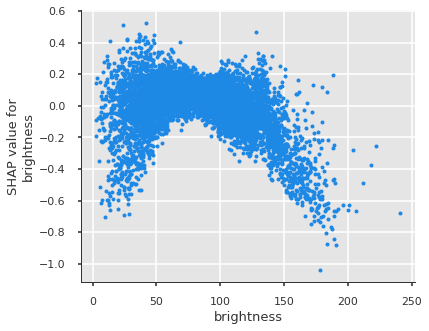

In [84]:
shap.dependence_plot('brightness', shap_values, X_test, 
                     interaction_index=None)

Using too bright thumbnails can be dissuasive for potential viewers. Maybe very bright films are considered as low-quality.

## Knowledge for the YouTuber

We can draw the following advices from the Neural Network analysis to increase the video's chances to get trending:
 * Don't disable comments
 * Use short, but informative description
 * If the content fits more than one category, choose the one increasing the odds of gettin trending. If you are the beginner and don't have strict vision for the channel - make videos associated with entertainment.
 * Build popularity not only on YouTube, but across the whole Internet,  
 * Including links in description can be helpful, but don't use too many links to social media
 * Title should be short (definitely shouldn't extend ~7 words)
 * Using a lot of capitals in the title is a good idea
 * Take care of the quality of thumbnail - don't use too bright ones 
 * Publish the video in the middle of the night
 * Be innovative in terms of using tags

